In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [4]:
db = "sqlite:///../../../data/data.db"
data = pd.read_sql('SELECT * FROM ohlc',db)

In [5]:
tokens = data.token.unique()

In [6]:
df = data[data.token=='BTC']

In [7]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [8]:
def df_merge(x,y):
    return pd.merge(x,y,on='ts',how='inner')

dfs = [
    (lambda x:
         x.assign(
             vol=vol_ohlc(x).fillna(0),
             ret_1 = x.close.pct_change(),
             ret_2 = x.close.pct_change(2),
             ret_3 = x.close.pct_change(3),
         )[['ts','vol','ret_1','ret_2','ret_3']]
         .rename(columns={
             col:f'{col}_{token}' for col in ['vol','ret_1','ret_2','ret_3']} )
    )(data[data.token == token])
    for token in tokens
]
X = reduce(df_merge,dfs).set_index('ts')

# Use more history return data!

In [9]:
X.tail()

,vol_BTC,ret_1_BTC,ret_2_BTC,ret_3_BTC,vol_ETH,ret_1_ETH,ret_2_ETH,ret_3_ETH,vol_USDT,ret_1_USDT,...,ret_2_CRV,ret_3_CRV,vol_AAVE,ret_1_AAVE,ret_2_AAVE,ret_3_AAVE,vol_COMP,ret_1_COMP,ret_2_COMP,ret_3_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,0.005215,0.003295,0.158369,0.005961,0.003021,0.001857,0.002463,0.0001,...,-0.003030,-0.012012,0.207758,0.009387,0.003477,0.002254,0.284268,0.006813,-0.004693,-0.023614
2021-12-14 21:00:00,0.142237,0.019797,0.024702,0.025115,0.170096,0.016737,0.022797,0.019808,0.002652,0.0000,...,0.024390,0.018182,0.222014,0.022490,0.032088,0.026045,0.281497,0.017473,0.024405,0.012698
2021-12-14 22:00:00,0.151148,0.010414,0.030417,0.035374,0.172081,0.004623,0.021437,0.027526,0.002684,0.0000,...,0.045593,0.048780,0.220598,0.006242,0.028872,0.038530,0.275083,0.009868,0.027513,0.034514
2021-12-14 23:00:00,0.149424,-0.000302,0.010109,0.030106,0.170257,-0.003195,0.001413,0.018174,0.002823,0.0001,...,0.011905,0.033435,0.219474,-0.003013,0.003210,0.025772,0.271229,-0.000864,0.008995,0.026625
2021-12-15 00:00:00,0.143079,-0.001448,-0.001749,0.008647,0.159883,-0.000641,-0.003834,0.000772,0.002816,0.0000,...,-0.014535,0.008929,0.213360,0.001659,-0.001359,0.004875,0.246067,-0.001027,-0.001889,0.007959


In [10]:
y = X.ret_1_SOL.shift(-1)[:-1]
X = X[:-1]

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [13]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0]*test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [14]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', RandomForestRegressor(n_estimators=1000,max_depth=1))
])

evaluate_model(pipeline, X, y)

-0.008564073770823731

In [80]:
pipeline = Pipeline([
    ('feature_selec', FeatureSelector(['ret_1_SOL', 'ret_2_SOL', 'ret_3_SOL', 'vol_SOL'])),
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', RandomForestRegressor(n_estimators=1000,max_depth=1))
])

evaluate_model(pipeline, X, y)

-0.008588713760508418

In [61]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', AdaBoostRegressor(n_estimators=1000))
])

evaluate_model(pipeline, X, y)

-0.009651347749041262

In [64]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', Ridge(alpha=.1))
])

evaluate_model(pipeline, X, y)

-0.008555061327190706

In [70]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('pca', PCA(10)),
    ('model', Ridge(alpha=.1))
])

evaluate_model(pipeline, X, y)

-0.008655007861243836

In [72]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', Lasso(alpha=.1))
])

evaluate_model(pipeline, X, y)

-0.008570816681474391

In [79]:
pipeline = Pipeline([
    ('feature_selec', FeatureSelector(['ret_1_SOL', 'ret_2_SOL', 'ret_3_SOL', 'vol_SOL'])),
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('model', Ridge(alpha=.1))
])

evaluate_model(pipeline, X, y)

-0.008598563138126458

In [102]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', SVR())
])

evaluate_model(pipeline, X, y)

-0.008546201345938906

# SVR doesn need for fine-tune
# we fine-tune the hyperparameters of Ridge Model

In [118]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0.)),
    ('sacle', StandardScaler()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0]*test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(
    pipeline,
    {
    'model__alpha':[0.01, 0.1, 1, 10, 100]
    }
)
search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('sacle', StandardScaler()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]})

In [119]:
search.best_params_

{'model__alpha': 100}

In [120]:
best_model = search.best_estimator_
evaluate_model(best_model, X, y)

-0.008498910531781468

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/mfe-preprogram/lib/python3.8/site-packages/matplotlib/pyplot.py'>

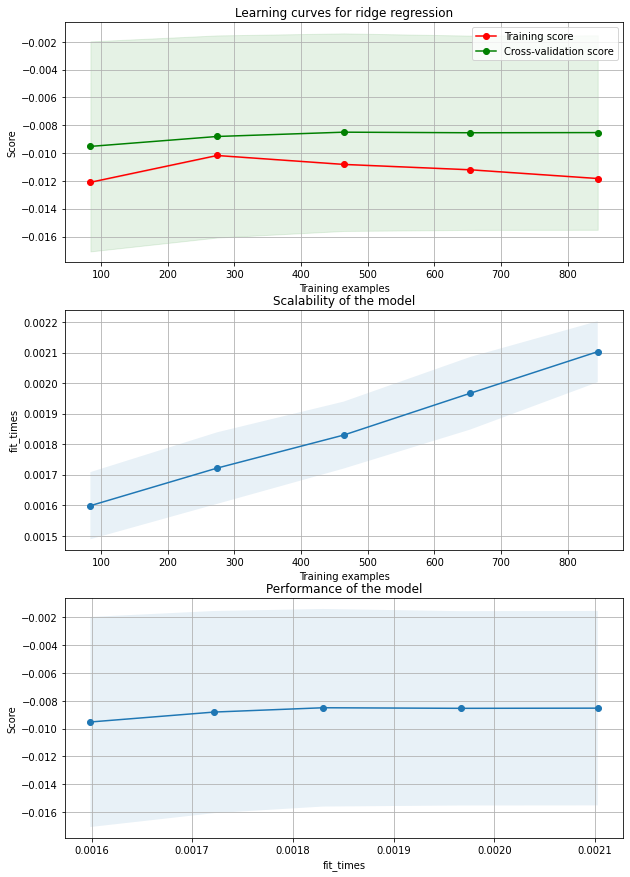

In [123]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


In [125]:
pickle.dump(best_model,open('best_model.pkl','wb'))

In [126]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [127]:
loaded_model.predict(X.iloc[[-1]])

array([-0.00315665])

In [128]:
best_model.predict(X.iloc[[-1]])

array([-0.00315665])